# Muon Tracks in CMS - worked example  
This is a worked example of the Coding Camp 2 activity. Analysis is based on [Natasha Holmes' weighted chi-sq](https://docs.google.com/document/d/1VP2fAFiVm1FqjqD4D-jRctjdIrMiSmBWAYw_cqBhxV0/edit?usp=sharing).

## Problem  
How does the magnetic field in CMS affect a muon's trajectory?  

## Plan  
Fit model functions to CMS tracker data for a muon and evaluate using weighted chi-sq.  

## Data  
For muon track 1, pt = 25 GeV, particle is a muon with q= -1. muon_track_1.csv has 3 rows of header info to ignore for analysis as a pandas dataframe. Data include x,y coordinates of the muon's trajectory but not z. The tracker has a spatial resolution on the order of 0.5 cm due to physical size of the hardware elements.  

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

In [2]:
track = pd.read_csv('https://github.com/QuarkNet-HEP/coding-camp/raw/main/data/muon_track_1.csv', skiprows=2)
track.head()

x         y
0  0.038726 -0.015958
1  0.131212 -0.055478
2  0.223866 -0.094564
3  0.316684 -0.133215
4  0.409664 -0.171429

## Analysis  
Two model functions, one linear and one curved, are fit to the x,y tracker data. Applying classical mechanics to the muon, its path is expeted to curve in a circular arc due to the Lorentz force. The 'curved' model function is that of a circular arc with center a distance, r, fand in a direction, theta, from the origin. Following Holme's *Statistics Summary*, a weighted chi-sq is calculated for each model.  

In [3]:
# fit a linear model to a set of muon tracks in CMS

def linear_model(x, m, b):   # x and y are track coordinates, scipy will optimize m & b to fit
    y = m * x + b
    return(y)

popt, pcov = curve_fit(linear_model, track['x'], track['y'])
linear_params = popt
linear_params

array([-0.3862925 , -0.01158637])

In [4]:
# circular curvature using classical Lorentz force
# for a circle with center at r, theta from the origin: y r*sin(theta)-sqrt(r^2-(x-r*cos(theta))^2)
def curved_model(x, r, theta):   # x and y are track coordinates, scipy will optimize r & theta to fit
    y = r*np.sin(theta)-np.sqrt(r**2-(x-r*np.cos(theta))**2)
    return(y)

popt, pcov = curve_fit(curved_model, track['x'], track['y'], p0=[30,1])
curved_params = popt
curved_params

array([38.32186923,  1.1738638 ])

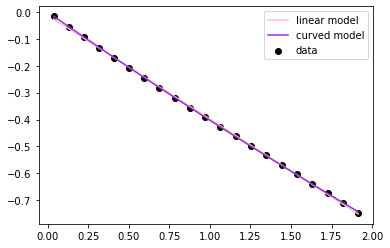

In [5]:
# compare the two models using chi-sq

# plotting the original data and the optimized model (i.e., trendline)
plt.scatter(track['x'], track['y'], label="data", color='k')
plt.plot(track['x'], linear_model(track['x'], linear_params[0], linear_params[1]), label="linear model", color='pink')
plt.plot(track['x'], curved_model(track['x'], curved_params[0], curved_params[1]), label="curved model", color='darkorchid')
plt.legend()
plt.show()

In [6]:
track['linear model yvals'] = linear_model(track['x'], linear_params[0], linear_params[1])
track['curved model yvals'] = curved_model(track['x'], curved_params[0], curved_params[1])
track['linear model residuals'] = track['y'] - track['linear model yvals']
track['curved model residuals'] = track['y'] - track['curved model yvals']
track.head()

x         y  linear model yvals  curved model yvals  \
0  0.038726 -0.015958           -0.026546           -0.016208   
1  0.131212 -0.055478           -0.062273           -0.054716   
2  0.223866 -0.094564           -0.098064           -0.093009   
3  0.316684 -0.133215           -0.133919           -0.131086   
4  0.409664 -0.171429           -0.169837           -0.168946   

   linear model residuals  curved model residuals  
0                0.010588                0.000251  
1                0.006795               -0.000762  
2                0.003500               -0.001555  
3                0.000704               -0.002129  
4               -0.001592               -0.002483

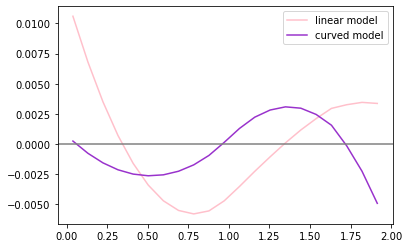

In [7]:
# plotting the residuals
plt.plot(track['x'], track['linear model residuals'], color='pink', label="linear model")
plt.plot(track['x'], track['curved model residuals'], color='darkorchid', label="curved model")
plt.axhline(0, color='grey')
plt.legend()
plt.show()

In [8]:
unc = 0.005    # estimate of tracker uncertainty due to pixel and strip dimensions, in m
linear_chisq = (track['linear model residuals']**2).sum() / (unc**2 * track['y'].count())
np.round(linear_chisq,3)

0.744

In [9]:
curved_chisq = (track['curved model residuals']**2).sum() / (unc**2 * track['y'].count())
np.round(curved_chisq,3)

0.203

In [10]:
curved_params   # [r , theta]

array([38.32186923,  1.1738638 ])

In [11]:
# classically
# F=qvB --> mv/r=qB --> r=mv/qB --> r=p/qB --> p=qrB
q = 1 * 10**-19   # |q| = e
B = 4              # CMS field strength inside the solenoid, in Telsa
p = q * curved_params[0] * B   # p = qrB, in kg*m/s
p = p / (5.36 * 10**-28)        # p, in eV/c
np.format_float_scientific(p, precision=3) # p, in eV/c

'2.86e+10'

## Conclusion  
As expected, the curved model has a smaller chi-sq indicating a better fit to the tracker data than the linear model. The optimized fit for the curved model gives a radius of 38.3 meters. Applying classical mechanics, that radius implies a transverse momentum for the muon of 28.6 GeV/c, similar to the given 25 GeV/c from the source data. The residaul plot has a definite structure, however, showing that neither model adequately caputures the physics driving the muon's trajectory, likely due to the muon's relativistic motion, the approximation that the motion was entirely in the transverse plane, or both. Further analysis with an appropriate 3D relativistic kinematic model is in order.